In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
!wget --quiet -O escapecalculator.py https://raw.githubusercontent.com/jbloomlab/SARS2-RBD-escape-calc/main/escapecalculator.py

In [3]:
import numpy as np
import pandas as pd
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated

In [4]:
# gene lengths
glen = {'E': 228,
        'M': 669,
        'N': 1260,
        'ORF10': 117,
        'ORF1ab': 13218,
        'ORF3a': 828,
        'ORF6': 186,
        'ORF7a': 366,
        'ORF7b': 132,
        'ORF8': 366,
        'S': 3822}

In [5]:
mutated = get_rbd_mutated('../out/time-filtered-lineages/')

In [6]:
a = read_mi('../out/all-notime/mi_annotated.tsv.gz', date=False)

In [7]:
ml_metrics(a, mutated=mutated)

(0.5384615384615384,
 0.5384615384615384,
 0.6363636363636364,
 0.5555555555555556,
 0.5334986442129299,
 0.6785714285714286)

In [8]:
ag = a[(~a['gene_source'].isna()) & (~a['gene_target'].isna())].copy()
ag.groupby(['gene_source', 'interaction'])['pos_source'].count()

gene_source  interaction   
E            different gene      3
M            different gene     11
             same gene           6
N            different gene     21
             same gene           8
ORF10        different gene      1
             same gene           2
ORF1ab       different gene     56
             same gene         122
ORF3a        different gene     10
ORF6         different gene      4
ORF7a        different gene      4
             same gene           2
ORF7b        different gene      3
ORF8         different gene      7
             same gene          10
S            different gene     52
             same gene         130
Name: pos_source, dtype: int64

In [9]:
slen1 = pd.Series(glen).reset_index().rename(columns={'index': 'gene_source'})
slen1['interaction'] = 'same gene'
slen2 = pd.Series(glen).reset_index().rename(columns={'index': 'gene_source'})
slen2['interaction'] = 'different gene'
slen = pd.concat([slen1, slen2]).set_index(['gene_source', 'interaction'])[0]

In [10]:
icount = ag.groupby(['gene_source', 'interaction'])['pos_source'].count() / slen
icount.name = 'proportion'
icount = icount.reset_index().dropna()
icount

,gene_source,interaction,proportion
0,E,different gene,0.013158
2,M,different gene,0.016442
3,M,same gene,0.008969
4,N,different gene,0.016667
5,N,same gene,0.006349
6,ORF10,different gene,0.008547
7,ORF10,same gene,0.017094
8,ORF1ab,different gene,0.004237
9,ORF1ab,same gene,0.009230
10,ORF3a,different gene,0.012077


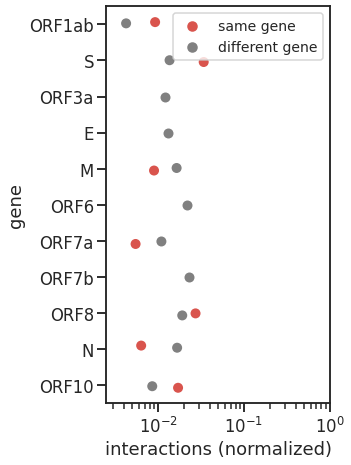

In [11]:
plt.figure(figsize=(4, 7.3))

sns.stripplot(data=icount,
            x='proportion',
            y='gene_source',
            hue='interaction',
            order=['ORF1ab', 'S', 'ORF3a', 'E',
                   'M', 'ORF6', 'ORF7a', 'ORF7b',
                   'ORF8', 'N', 'ORF10'],
            hue_order=['same gene',
                       'different gene'],
            palette=['xkcd:pale red',
                     'grey'],
            size=10)

plt.legend(facecolor='w', fontsize=14)

plt.xlim(2.5E-3, 1)
plt.xscale('log')

plt.ylabel('gene')
plt.xlabel('interactions (normalized)')

plt.savefig('same_diff_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('same_diff_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [12]:
c = {i+1: color
     for i, color in enumerate(sns.color_palette('crest_r', 4))}

In [13]:
norm = colors.Normalize(vmin=0, vmax=a['mi'].max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

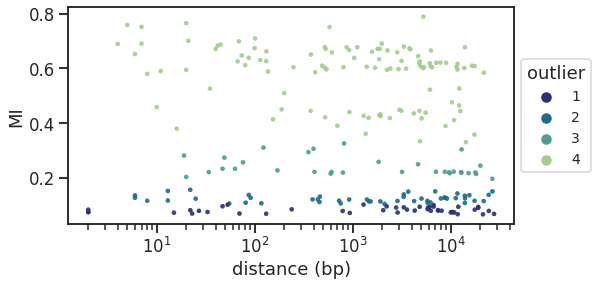

In [14]:
# distance Vs. MI
plt.figure(figsize=(8,4));
sns.scatterplot(data=a, x='distance', y='mi',hue="outlier", linewidth=0, alpha = 0.7, s=20, palette="crest_r");
plt.legend(facecolor='w', fontsize=14, loc='center left',
           bbox_to_anchor=(1, 0.5), title='outlier')
plt.xlabel('distance (bp)')
plt.ylabel('MI')
plt.xscale('log')
plt.savefig('distance_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('distance_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

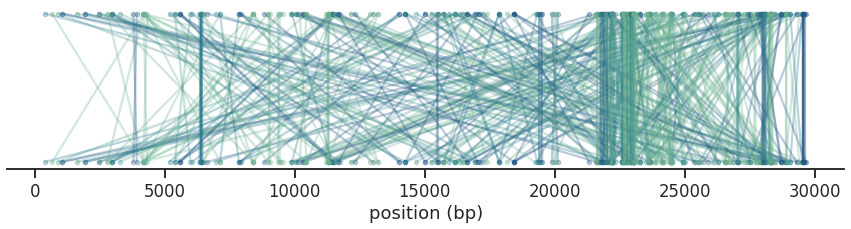

In [15]:
plt.figure(figsize=(15, 3))
for p1, p2, o in a[['pos_source', 'pos_target', 'outlier']].values:
    plt.plot([p1, p2],
             [0, 1], '.-',
             color=c[o], rasterized=True,
             alpha=0.3)
plt.yticks([])
plt.xlabel('position (bp)')
sns.despine(left=True)
# plt.fill_between([22520, 23186],
#                  [1.05, 1.05],
#                  [1.1, 1.1],
#                  color='r',
#                  alpha=0.3,
#                  zorder=10)
plt.savefig('interactions_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('interactions_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [16]:
# plt.figure(figsize=(15, 4))
# for p1, p2, o in a[(a['gene_source'] == 'S') &
#                    (a['gene_target'] == 'S') &
#                    (a['pos_source'] > 22519) &
#                    (a['pos_source'] < 23186) &
#                    (a['pos_target'] > 22519) &
#                    (a['pos_target'] < 23186)][['pos_source', 'pos_target', 'outlier']].values:
#     plt.plot([p1, p2],
#              [0, 1], '.-',
#              color=c[o], rasterized=True,
#              alpha=1,
#              zorder=-2)
# plt.xlim(22520, 23186)
# # plt.fill_between([22520, 23186],
# #                  [1.05, 1.05],
# #                  [1.1, 1.1],
# #                  color='r',
# #                  alpha=0.3,
# #                  zorder=10)
# values = a[(a['feature_codon_source'].isin(AFFINITY)) &
#            (a['gene_source'] == 'S')]['pos_source'].unique()
# plt.plot(values, [1] * len(values), 'o', color='r', label='affinity')
# values = a[(a['feature_codon_source'].isin(ESCAPE)) &
#            (a['gene_source'] == 'S')]['pos_source'].unique()
# plt.plot(values, [0] * len(values), 'o', color='b', label='escape')
# values = a[(a['feature_codon_source'].isin(MOI)) &
#            (a['gene_source'] == 'S')]['pos_source'].unique()
# plt.plot(values, [0] * len(values), 'o', color='orange', label='MOI/MOC', zorder=-1)

# plt.legend(facecolor='w', fontsize=14);

In [17]:
# plt.figure(figsize=(15, 3))
# for p1, p2, o in a[['pos_source', 'pos_target', 'mi']].values:
#     plt.plot([p1, p2],
#              [0, 1], '.-',
#              color=mapper.to_rgba(o), rasterized=True,
#              alpha=0.3);

In [18]:
df = enrichment(a, mutated, 'RBD.gml')

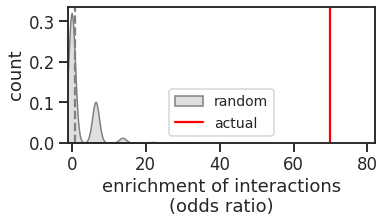

In [19]:
plt.figure(figsize=(5.5, 2.5))
sns.kdeplot(df[(df['type'] != 'original') &
               (df['randomization'] == 'any_positions')]['odds-ratio'],
            # bw_adjust=1.5,
            color='grey', label='random',
            fill=True)
plt.axvline(df[(df['type'] == 'original') &
               (df['randomization'] == 'any_positions')]['odds-ratio'].values,
            color='r',
            label='actual')
plt.axvline(1,
            color='grey', ls='dashed')
plt.ylabel('count')
plt.xlabel('enrichment of interactions\n(odds ratio)')
plt.legend(facecolor='w', fontsize=14)

plt.xlim(-1, 82)
plt.xticks([0, 20, 40, 60, 80])

plt.savefig('enrichment_all.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('enrichment_all.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [20]:
df.groupby(['type', 'randomization']).median()

,,round,odds-ratio,p-value
type,randomization,,,
original,any_positions,NaN,69.853448,1.407588e-10
random,any_positions,500.5,0.000000,1.000000e+00


In [21]:
df = enrichment(a[a['outlier'] > 2])

In [22]:
df.groupby(['type', 'randomization']).median()

,,round,odds-ratio,p-value
type,randomization,,,
original,any_positions,NaN,104.797414,1.850611e-11
random,any_positions,500.5,0.000000,1.000000e+00
